# RNN with Keras

We will train an RNN, with the application of [predicting word completions](http://curiousily.com/data-science/2017/05/23/tensorflow-for-hackers-part-5.html) for [Jonathan Swift](https://en.wikipedia.org/wiki/Jonathan_Swift), the author of Gulliver's Travels.

We will use Keras with a very popular RNN architecture called LSTM.

In [1]:
import pickle
import numpy as np

import keras
print('Keras', keras.__version__)
from keras import backend as K
print('GPU:', K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


Keras 2.2.4
GPU: []


The data is at `../data/Gulliver.txt` and contains the Project Gutenberg's version of the book.

We create mappings from characters to integers and from integers to characters:

In [2]:
with open('../data/Gulliver.txt') as f:
    text = f.read().lower()

chars = sorted(set(text)) # returns a sorted list
# create mapping from char to index and vice versa
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print('unique chars:', len(chars))

unique chars: 59


We'll use sequences of length 40 and unroll 3 steps at a time.

The following generates `X` and `Y`.
Make sure you understand what's going on.

In [3]:
seq_len = 40
step = 3

sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i + seq_len]) # preparing X 
    next_chars.append(text[i + seq_len]) # preparing y
print('num training examples:', len(sentences))

num training examples: 102845


In [4]:
# one-hot encoding
X = np.zeros((len(sentences), seq_len, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sent in enumerate(sentences):
    for t, char in enumerate(sent):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

**Create the model using Keras**.
An [LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) (a common and efficient type of RNN) with 128 hidden nodes, followed by a multinomial logistic layer.

In [ ]:
layers = [
    # add keras layers here
]
model = keras.models.Sequential(layers)
model.summary()

In [6]:
optimizer = keras.optimizers.Adam()
model.compile(
    # add training configuration here
)

To measure accuracy on a test set, we tell Keras to split of the data for a train and test set.

Other training parameters are the batch size - number of samples or sequences per gradient update - and epochs - number of times we want to iterate over the entire data.

**Choose the training parameters and run the training**. This may take about 30-60 secons per epoch.

In [ ]:
test_size = # choose training parameters
batch_size = #
epochs = #

history = model.fit(
    X, y, 
    validation_split=test_size, 
    batch_size=batch_size, 
    epochs=epochs, 
    shuffle=True).history

We save the models and the history and then reload them:

In [40]:
model.save('../data/keras_rnn_model.h5')
with open("history.p", "wb") as f:
    pickle.dump(history, f)

In [ ]:
model = keras.models.load_model('../data/keras_rnn_model.h5')
with open("history.p", "rb") as f:
    history = pickle.load(f)

Here we plot the change in accuracy and loss over the training time:

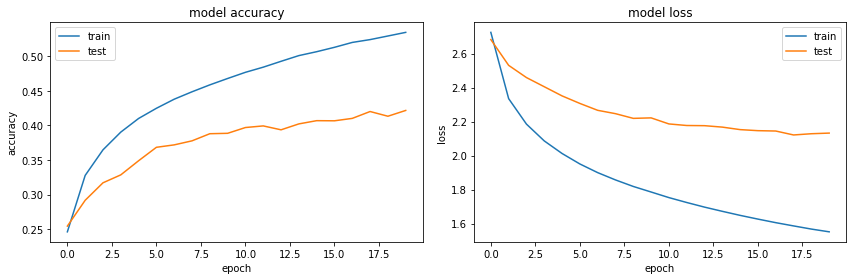

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(history['acc'], label='train')
ax.plot(history['val_acc'], label='test')
ax.set(
    title='model accuracy',
    ylabel='accuracy',
    xlabel='epoch'
)
ax.legend()

ax = axes[1]
ax.plot(history['loss'], label='train')
ax.plot(history['val_loss'], label='test')
ax.set(
    title='model loss',
    ylabel='loss',
    xlabel='epoch'
)
ax.legend()
    
fig.tight_layout()

Now let's apply the model for text completion.

First, a one-hot encoder.

In [10]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(chars)))
    for t, char in enumerate(text[:seq_len]):
        x[0, t, char_indices[char]] = 1.        
    return x

The next function samples from $\widehat y$, the next-character probability distribution, by taking the `top_n` characters with the highest probability:

In [45]:
def sample(preds, top_n):
    return [
        indices_char[i] 
        for i in np.argsort(preds.squeeze())[-top_n:]
    ]

The next two function gets input text and predicts at least two more characters until space is encountered.

In [47]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_char = sample(preds, top_n=1)[0]

        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

Finally, the next one makes several predictions, that is, samples the highest probability completions.

In [51]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_chars = sample(preds, n)
    return [
        char + predict_completion(text[1:] + char) 
        for char in next_chars
    ]

Let's try it with some actual quotes from the book.

In [52]:
quotes = [
    'I likewise delivered up my watch, which the emperor was very curious to see',
    'I lay all this while, as the reader may believe, in great uneasiness.',
    'But I should have mentioned, that before the principal person began his oration',
    'After they were read, I was demanded to swear to the performance of them',
    'extending its edges round as wide as his majesty\'s bed-chamber'
]

In [54]:
for q in quotes:
    seq = q[:seq_len].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

i likewise delivered up my watch, which 
['all ', 'had ', 'the ', 'was ', 'i ']

i lay all this while, as the reader may 
['which ', 'a ', 'he ', 'the ', 'of ']

but i should have mentioned, that before
['s ', '. ', '\nhis ', ', ', ' of ']

after they were read, i was demanded to 
['see ', 'his ', 'be ', 'my ', 'the ']

extending its edges round as wide as his
[', ', 'e ', 'her ', '\nmajesty ', ' majesty ']



# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Deep Learning for Software Developers_](https://python.yoavram.com/Deep4Devs) course.

The notebook was written using [Python](http://python.org/) 3.6.3, [IPython](http://ipython.org/) 6.2.1, [Jupyter](http://jupyter.org) 5.1.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)